
Goal
- verify if there is correlation between P_LM with output token length
- analyze difference/similarity between sorted indices with different `sort_by`. see if they correlate with each other, e.g., first k item overlap
- visualize text statistics w.r.t. data subsets obtaind from pruning






In [3]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import sys
import numpy as np
import time
import re
from functools import partial

import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
from transformers import AutoTokenizer

from datasets import load_dataset

In [7]:
def get_lm_output(dataset):
    lm_output_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/llama-7b_outputs'
    save_path = os.path.join(lm_output_dir, f'{dataset}.pkl')
    with open(save_path, 'rb') as f:
        output = pickle.load(f)
    output['log_probs'] = np.nan_to_num(output['log_probs'], nan=np.nanmean(output['log_probs']))
    return output


def get_dataset(dataset):
    processed_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/data/processed'
    if 'tulu' in dataset:
        train_file = os.path.join(processed_dir, 'tulu', f'{dataset}.jsonl')
    else:
        train_file = os.path.join(processed_dir, dataset, f'{dataset}_data.jsonl')
    data_files = {'train': train_file}
    ds = load_dataset('json', data_files=data_files)['train']
    return ds



tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


def get_dataset_token_lengths(dataset, model_name_or_path, inds=None):
    from open_instruct.finetune_trainer import encode_with_messages_format

    ds = get_dataset(dataset)
    if inds is not None: ds = ds.select(inds)
    encode_fn = partial(encode_with_messages_format, tokenizer=tokenizer, max_seq_length=2048)
    ds = ds.map(encode_fn, batched=False, num_proc=16)
    ds.set_format(type='np')

    def count_token_lengths(d):
        x = d['labels']
        input_len = x[x==-100].shape[0]
        output_len = x.shape[0] - input_len
        return {'input_len': input_len, 'output_len': output_len}

    ds = ds.map(count_token_lengths, num_proc=16)
    return {'input_len': ds['input_len'], 'output_len': ds['output_len']}


def get_sorted_inds(dataset, sort_by):
    inds_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b'
    save_path = os.path.join(inds_dir, dataset, f'{sort_by}.pkl')
    with open(save_path, 'rb') as f:
        output = pickle.load(f)
    return output

Using pad_token, but it is not set yet.


In [6]:
dataset = 'flan_v2'
model_name_or_path='../results/baselines/huggyllama/llama-7b'

dataset_list = ['baize', 'code_alpaca', 'cot', 
                'dolly', 'flan_v2', 'gpt4_alpaca', 
                'lima', 'oasst1', 'open_orca', 
                'self_instruct', 'sharegpt', 'stanford_alpaca', 
                'super_ni', 'unnatural_instructions', 'wizardlm',
                'tulu_v1_human_mix'
               ]


In [12]:
subsample_size = 2000

lm_outputs = {}
token_lengths = {}
for dataset in dataset_list:
    lm_outputs[dataset] = get_lm_output(dataset)
    if subsample_size:
        np.random.seed(0)
        inds = np.random.randint(0, list(lm_outputs[dataset].values())[0].shape[0], subsample_size)
    for k, v in lm_outputs[dataset].items():
        lm_outputs[dataset][k] = v[inds]
    token_lengths[dataset] = get_dataset_token_lengths(
        dataset, model_name_or_path, inds=inds if subsample_size else None)

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-9baadeb2fbd2bc2a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-9baadeb2fbd2bc2a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-19337812ebb30070_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-9baadeb2fbd2bc2a/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-d98c59296abb4f82_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-074141fac9aa8188/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-074141fac9aa8188/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-8d157db68e048508_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-074141fac9aa8188/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-83205ad61745af35_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-eb938f2a6da5e5da_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-52fb5309cd37411e_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-56e3fe188fc9e223_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-c7cf7bedaf1dfc6d_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a5113a0d5a91ea53_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-201a8fdb5debb8f4_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-cdbeb71d4bf095da/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-cdbeb71d4bf095da/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-768e06bac642b89a_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-cdbeb71d4bf095da/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-83dd13cfbbcd4947_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-c30f84a2dc784550_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-7f8f3578e19230dd_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-3da14401ed1f756e_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-8495599b1faf56c9_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-d844d421d66944c3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-d844d421d66944c3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-c30ea24499c866f0_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-d844d421d66944c3/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-9ddc62c9516add08_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-a491ee6f11e1b86e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-a491ee6f11e1b86e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-91023ad8d748d2d1_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-a491ee6f11e1b86e/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-3c391ca5940f2e48_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-27d716f852da215c_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ddd1a699a14e41bf/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-178e495461899c04_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-b6766d38a0ddb739/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-b6766d38a0ddb739/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-f281cc2dd1113320_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-b6766d38a0ddb739/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-cda40c4de8e4866c_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-fe3108b6d6ee8ac2/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-fe3108b6d6ee8ac2/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-9b89a650f59ccbad_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-fe3108b6d6ee8ac2/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-503572980b6b769b_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-8a3cbb403d846400/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-8a3cbb403d846400/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-cfadc15919c348f0_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-8a3cbb403d846400/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a8e0992bc295be4d_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-eb8df4a0cb6318e9_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-a3f71ae376e517fb/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-9693c75e29143d5c_*_of_00016.arrow
Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-beba94d5598bb97f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-beba94d5598bb97f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-ee7c5184723dc218_*_of_00016.arrow
Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-beba94d5598bb97f/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-3f484721f7356dae_*_of_00016.arrow


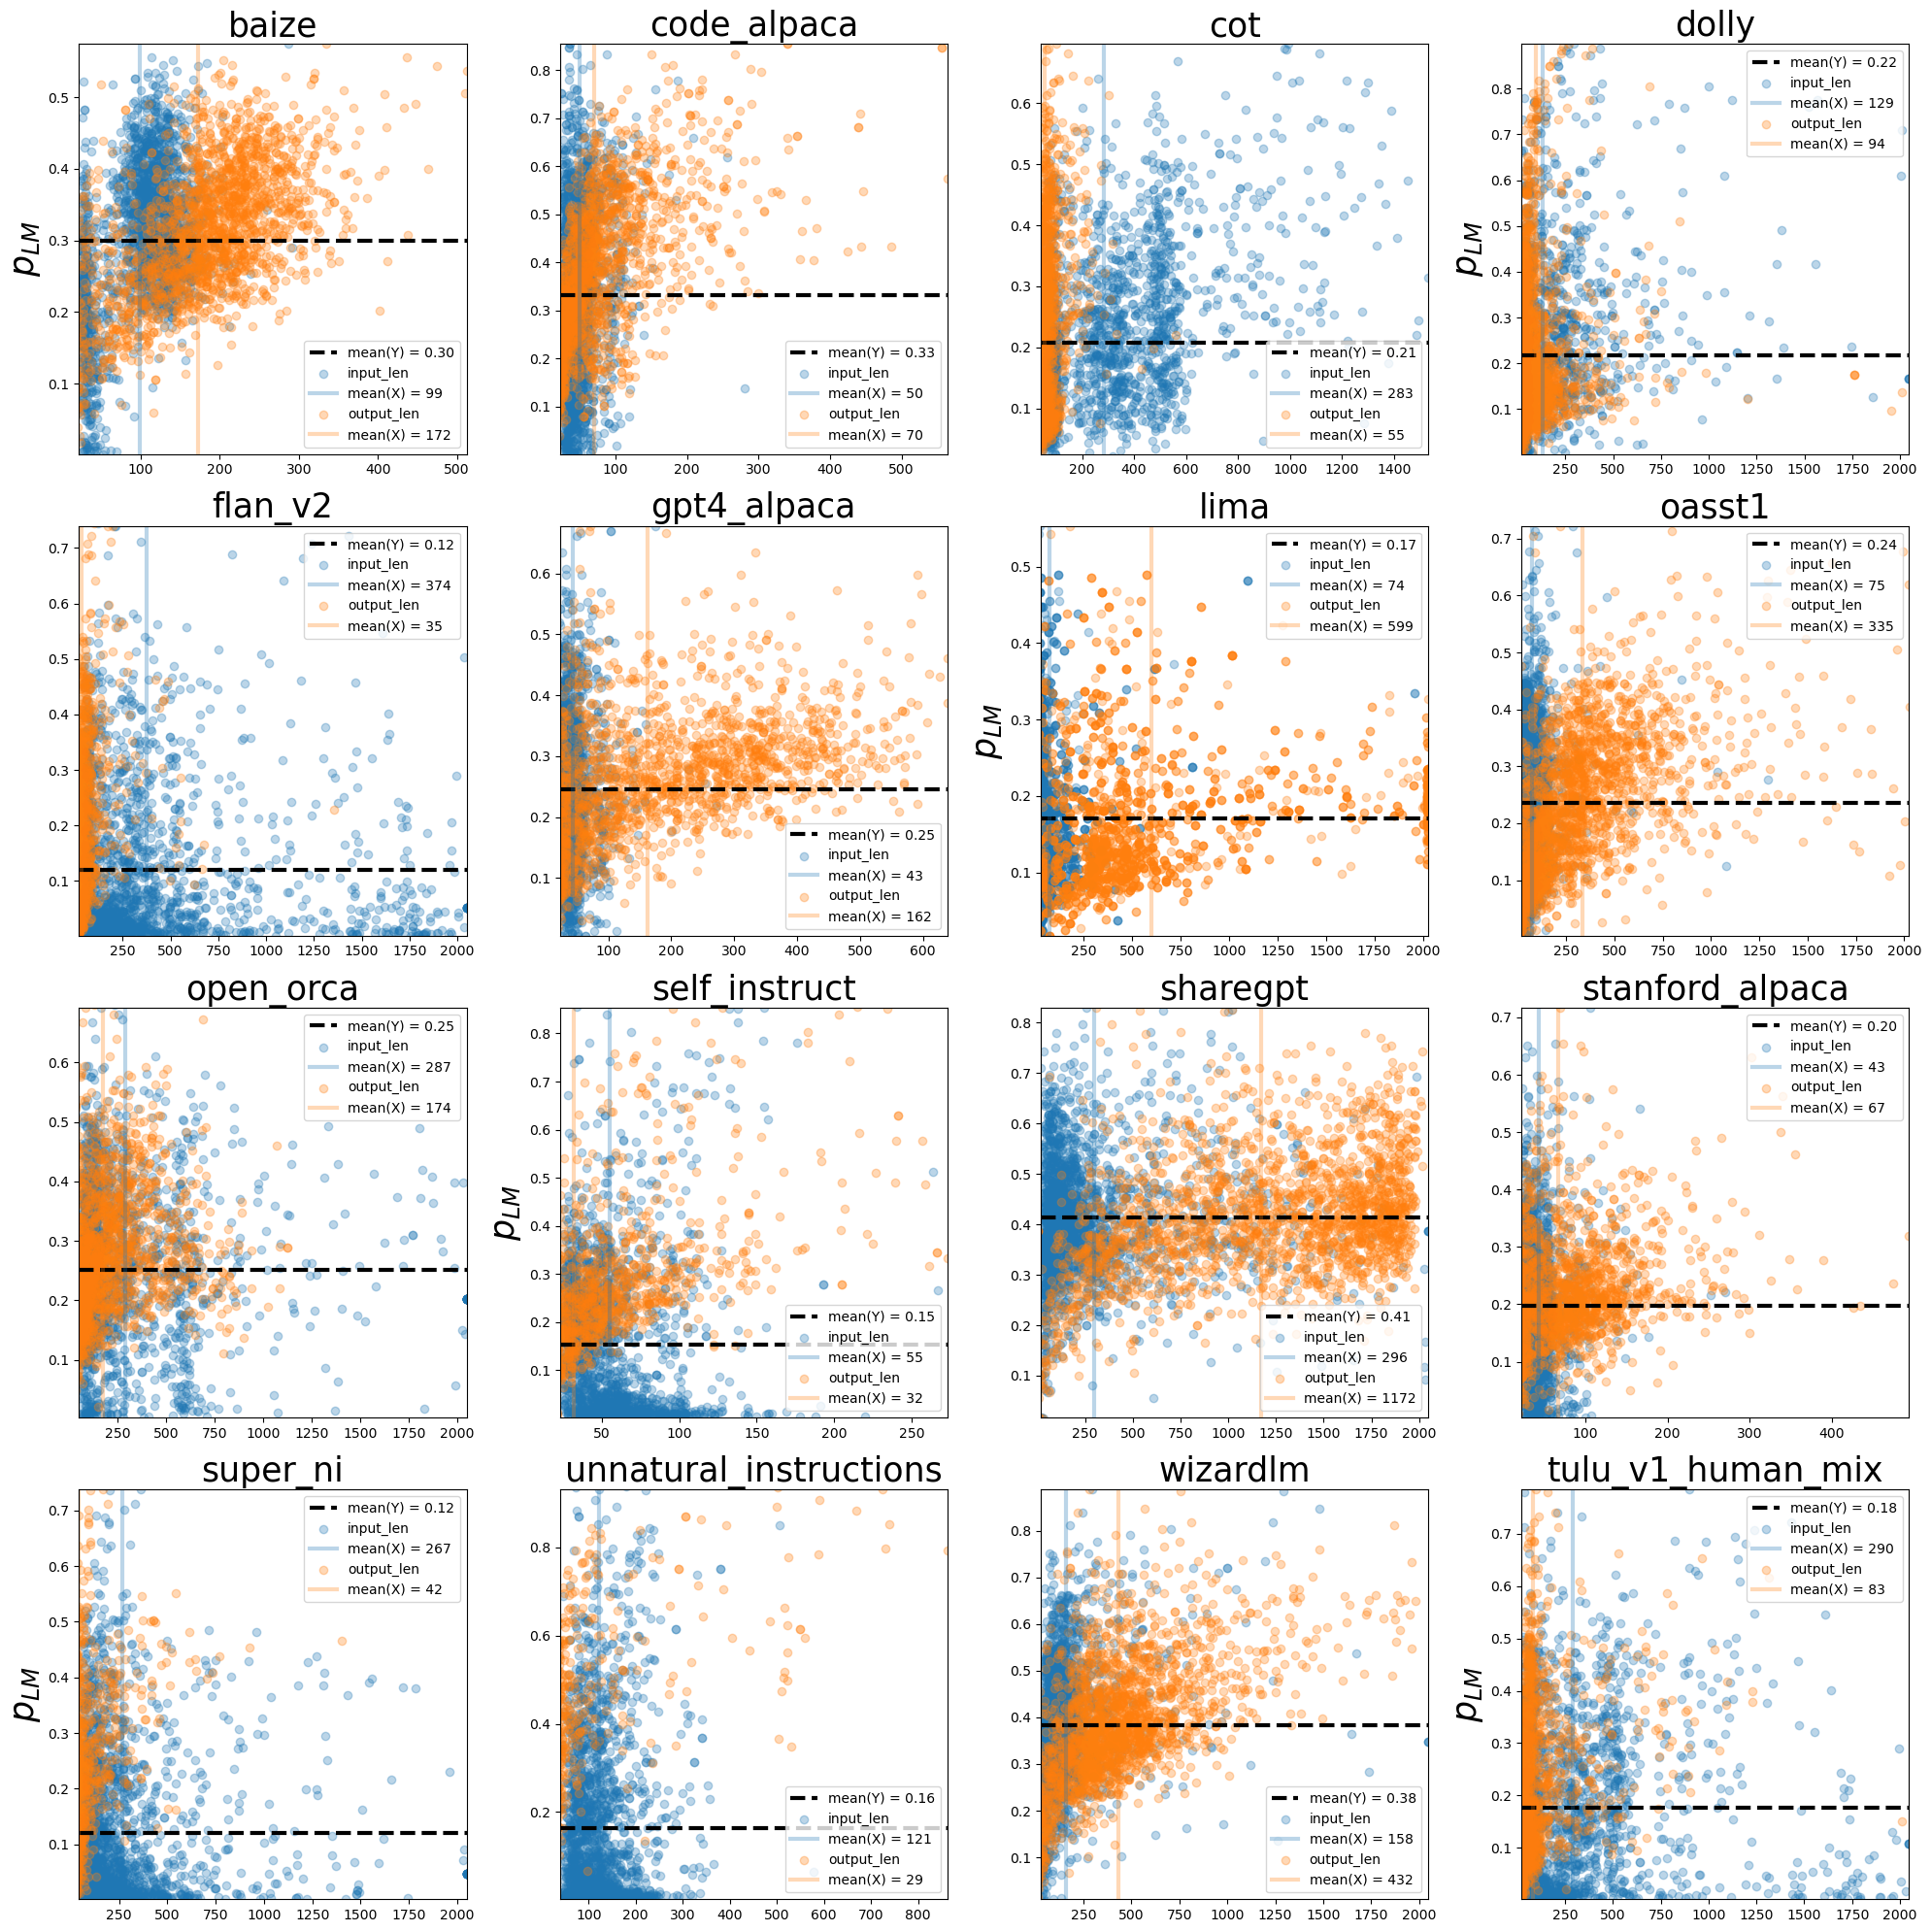

In [26]:


w = 5
fig, axs = plt.subplots(4,4, figsize=(w*4,w*4))


for axi, dataset in enumerate(dataset_list):
    
    ## get the information
    T = lm_outputs[dataset]['text_embeddings']
    logP = lm_outputs[dataset]['log_probs']
    
    input_len = token_lengths[dataset]['input_len']
    output_len = token_lengths[dataset]['output_len']
    
    ## plot the information 
    ax = axs.flatten()[axi]

    ys = np.exp(logP)
    mean_y = ys.mean()
    ax.axhline(y=mean_y, color='k', linestyle='--', linewidth=3, label=f'mean(Y) = {mean_y:.2f}')

    for label, xs in [
            ('input_len', input_len),
            ('output_len', output_len),
        ]:
        scatter = ax.scatter(xs, ys, label=label, alpha=.3)
        mean_x = xs.mean()
        ax.axvline(x=mean_x, color=scatter.get_facecolor()[0], linestyle='-', linewidth=3, label=f'mean(X) = {mean_x:.0f}')


    ax.legend()
    eps = .001

    ax.set_ylim(np.quantile(ys, eps), np.quantile(ys, 1-eps))
    xs_for_xlim = np.maximum(input_len, output_len)
    ax.set_xlim(np.quantile(xs_for_xlim, eps), np.quantile(xs_for_xlim, 1-eps))
    
    # ax.set_xlabel('token lengths', fontsize=20)
    if axi%3 == 0:
        ax.set_ylabel('$p_{LM}$', fontsize=25)
    ax.set_title(dataset, fontsize=25)

    
    
fig.tight_layout()
save_path = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/assets/note_pruning_analysis_prob_vs_tokenlen.png'
# fig.savefig(save_path, bbox_inches='tight', dpi=100)